# Credit Card Fraud Detection

## 🔹Step 1: Load and Inspect the Data

In [3]:
import pandas as pd

# Correct relative path to go one folder up, then into 'Data'
df = pd.read_csv('../Data/creditcard.csv')

# Confirm the data loaded
print("Shape of the dataset:", df.shape)
df.head()

Shape of the dataset: (284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## 🔹Step 2: Basic Data Exploration

In [5]:
# Check data types and non-null counts
df.info()

# Check for missing values
print("\nMissing values in each column:")
print(df.isnull().sum())

# Check class distribution (fraud vs non-fraud)
print("\nClass distribution:")
print(df['Class'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

## 🔹Step 3: Visualize Class Imbalance

Let’s create a simple count plot to visualize this imbalance.

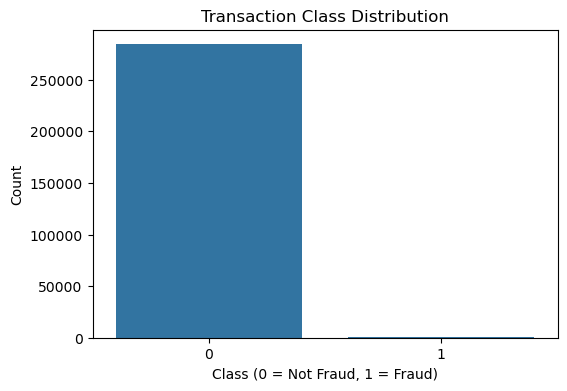

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 4))
sns.countplot(x='Class', data=df)
plt.title('Transaction Class Distribution')
plt.xlabel('Class (0 = Not Fraud, 1 = Fraud)')
plt.ylabel('Count')
plt.show()

## 🔹Step 4: Feature Scaling

Now we’ll standardize the only two features that need it:

Time — seconds since first transaction

Amount — transaction value

These haven’t been PCA-transformed like V1–V28, so scaling them helps many models perform better.

In [9]:
from sklearn.preprocessing import StandardScaler

# Create scaled versions
df['scaled_time'] = StandardScaler().fit_transform(df[['Time']])
df['scaled_amount'] = StandardScaler().fit_transform(df[['Amount']])

# Drop original columns
df.drop(['Time', 'Amount'], axis=1, inplace=True)

# Reorder columns: scaled_time, scaled_amount, V1–V28, Class
scaled_cols = ['scaled_time', 'scaled_amount']
pca_cols = [col for col in df.columns if col not in scaled_cols + ['Class']]
df = df[scaled_cols + pca_cols + ['Class']]

## 🔹Step 5: Split the Dataset

Now let’s split the data into features (X) and target (y), then create training and test sets.

We’ll use a stratified split to ensure both sets have the same fraud ratio.

In [11]:
from sklearn.model_selection import train_test_split

# Split features and target
X = df.drop('Class', axis=1)
y = df['Class']

# Stratified split to maintain class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Fraud cases in training set:", sum(y_train))
print("Fraud cases in test set:", sum(y_test))

Shape of X_train: (227845, 30)
Shape of X_test: (56962, 30)
Fraud cases in training set: 394
Fraud cases in test set: 98


## 🔹Step 6: Train a Baseline Classifier

Let’s start with Logistic Regression — simple, interpretable, and works well as a baseline.

We’ll handle class imbalance using class_weight='balanced', which tells the model to pay more attention to minority class (fraud).

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Initialize and train
lr = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
lr.fit(X_train, y_train)

# Predict
y_pred = lr.predict(X_test)

# Evaluate
print("Classification Report:\n", classification_report(y_test, y_pred, digits=4))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0     0.9999    0.9756    0.9876     56864
           1     0.0609    0.9184    0.1141        98

    accuracy                         0.9755     56962
   macro avg     0.5304    0.9470    0.5509     56962
weighted avg     0.9982    0.9755    0.9861     56962


Confusion Matrix:
 [[55475  1389]
 [    8    90]]


## 🔹Step 7: Train a Random Forest Classifier

Random Forest is great for:
- Handling imbalanced datasets (with class_weight='balanced')
- Capturing nonlinear patterns better than logistic regression

In [15]:
from sklearn.ensemble import RandomForestClassifier

# Initialize and train
rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf.fit(X_train, y_train)

# Predict
y_pred_rf = rf.predict(X_test)

# Evaluate
from sklearn.metrics import classification_report, confusion_matrix

print("Random Forest Classification Report:\n", classification_report(y_test, y_pred_rf, digits=4))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))

Random Forest Classification Report:
               precision    recall  f1-score   support

           0     0.9996    0.9999    0.9998     56864
           1     0.9605    0.7449    0.8391        98

    accuracy                         0.9995     56962
   macro avg     0.9800    0.8724    0.9194     56962
weighted avg     0.9995    0.9995    0.9995     56962


Confusion Matrix:
 [[56861     3]
 [   25    73]]


### ✅ Random Forest Classifier Evaluation
🔹 Confusion Matrix:
False Negatives (missed frauds) dropped from 8 → 25<br>
False Positives (flagging legit as fraud) dropped massively: 1389 → 3 🤯
<br>
### 🔹 Comparison: Logistic Regression vs Random Forest

<table>
    <tr>
        <th>Metric</th>
        <th>Logistic Regression</th>
        <th>Random Forest</th>
    </tr>
    <tr>
        <td>Precision (fraud)</td>
        <td>6.09% </td>
        <td>96.05% ✅</td>
    </tr>
    <tr>
        <td>Recall (fraud)</td>
        <td>91.84%✅</td>
        <td>74.49%</td>
    </tr>
    <tr>
        <td>F1-score (fraud)</td>
        <td>11.41% </td>
        <td>83.91%✅</td>
    </tr>
    <tr>
        <td>Accuracy</td>
        <td>97.55%</td>
        <td>99.95%✅</td>
    </tr>
</table>
Logistic Regression = high recall, low precision (catches more but over-flags)

Random Forest = balanced precision and recall, great overall

## 🔹Step 8: ROC Curve & AUC – Visual Evaluation

This will help you understand how well your model distinguishes between classes (fraud vs. legit) at various thresholds.

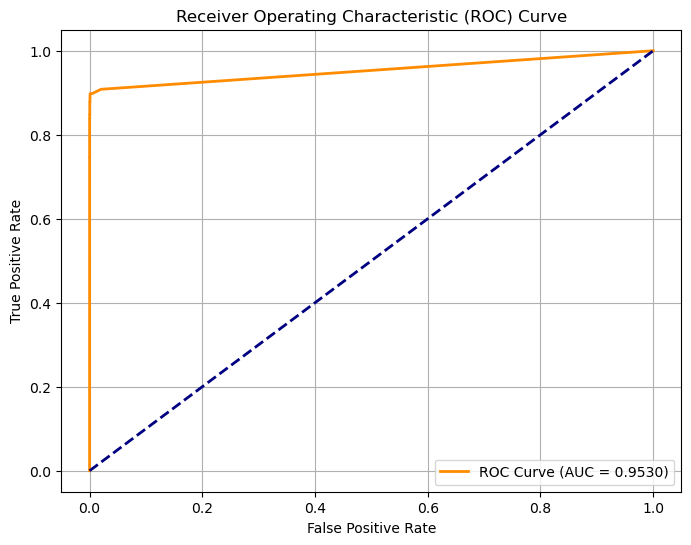

In [17]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get predicted probabilities
y_scores = rf.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()

## 🔹Step 9: Feature Importance

Let’s find out which features your Random Forest used most to detect fraud. Even though the features are anonymized (V1–V28), this helps in:
- Understanding model behavior
- Improving explainability in presentations
- Selecting features in future models

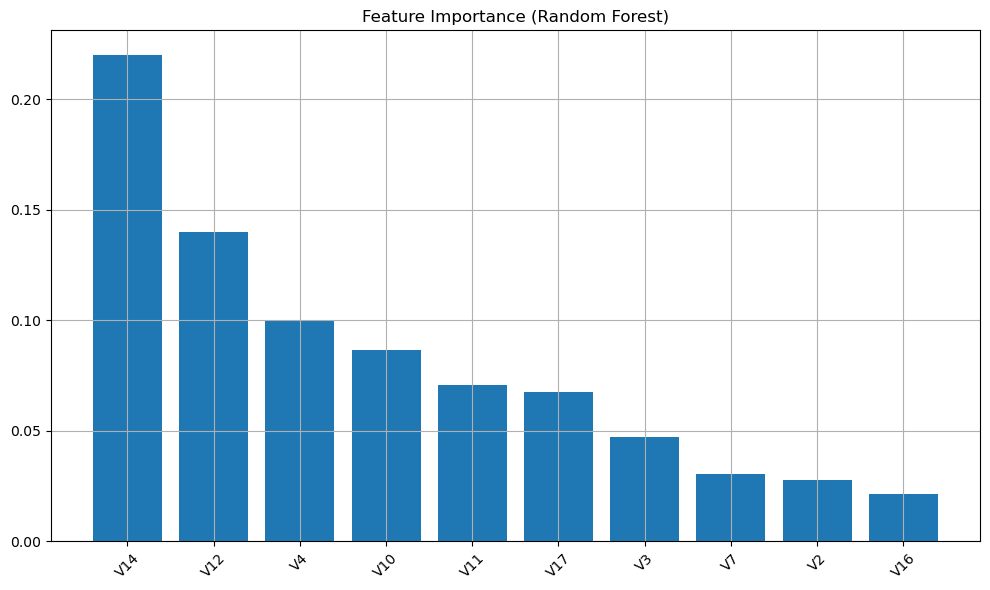

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Get feature importances
importances = rf.feature_importances_
features = X_train.columns
indices = np.argsort(importances)[::-1]

# Plot
plt.figure(figsize=(10, 6))
plt.title("Feature Importance (Random Forest)")
plt.bar(range(10), importances[indices[:10]], align='center')
plt.xticks(range(10), features[indices[:10]], rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()